In [160]:
import numpy as np
import numpy.linalg as nplin
import scipy.linalg as sclin
import matplotlib.pyplot as plt
import math as m

In [187]:
a = np.array([[2], [2], [2]])
b = np.array([[1, 5], [2, 6], [3, 7]])
print(a**3)
print(np.multiply(a[:, -1:], b[:, -1:]))
print(m.factorial(4))

[[8]
 [8]
 [8]]
[[10]
 [12]
 [14]]
24


In [428]:
# Définition des fonctions

def theta_model(theta:np.ndarray, beta:np.ndarray):
    return 1-np.cos(theta)+np.multiply(1+np.cos(theta), beta)

def spike_rep(theta:np.ndarray, n = 1):
   return (1-np.cos(theta))**n

def beta_Vconst(beta:float, beta_switch:bool, beta_low:float = -0.01, beta_high:float = 0.01):
    if beta >= 0.2:
       beta_switch = False
    elif beta <= -0.3:
       beta_switch = True
    if beta_switch:
        return beta_switch, beta_high
    else:
        return beta_switch, beta_low

def beta_const(beta:float, beta_switch:bool):
   return False, 0

def dynamique(time_step:int, time_stop:int, theta_0:float, beta_0:float, theta_model, beta_model, *kwarg):
  theta = np.array([theta_0])
  beta = np.array([beta_0])
  beta_switch = True
  for _ in range(int(time_stop/time_step)):
    Vtheta = theta_model(theta[-1], beta[-1])
    beta_switch, Vbeta = beta_model(beta[-1], beta_switch, *kwarg)
    theta = np.concatenate((theta, theta[-1:]+Vtheta*time_step))
    beta = np.concatenate((beta, beta[-1:]+Vbeta*time_step))
  return theta, beta

def betaNneurones(theta_list:np.ndarray, A:np.ndarray, n:int = 2, seuil:float=0, kapa:float = 1):
   N = len(theta_list)
   a_n = 2**n*(m.factorial(n))**2/m.factorial(2*n)
   beta = np.zeros(np.shape(theta_list))
   for i in range(N):
      beta[i, 0] = np.sum(spike_rep(np.multiply(A[i], theta_list.T[0]), n))
   return seuil + a_n*kapa*beta/N

def beta2neurones(theta:np.ndarray, n:int = 2, seuil:float=0, kapa:float = 1): # point critique n:int = 1, seuil:float=-0.184151
   a_n = 2**n*(m.factorial(n))**2/m.factorial(2*n)
   # a_n = 1/2**(n+1)
   beta = spike_rep(theta, n)*a_n*kapa
   beta[[0, 1], :] = beta[[1, 0], :]
   return seuil + beta

def dynamique2neurones(time_step:int, time_stop:int, theta_0:np.ndarray, theta_model, beta_model, *kwarg):
  theta = theta_0
  beta = beta_model(theta[:, -1:], *kwarg)
  for _ in range(int(time_stop/time_step)):
   Vtheta = theta_model(theta[:, -1:], beta[:, -1:])
   beta = np.concatenate((beta, beta_model(theta[:, -1:], *kwarg)), axis=1)
   theta = np.concatenate((theta, theta[:, -1:]+Vtheta*time_step), axis=1)
  return theta, beta

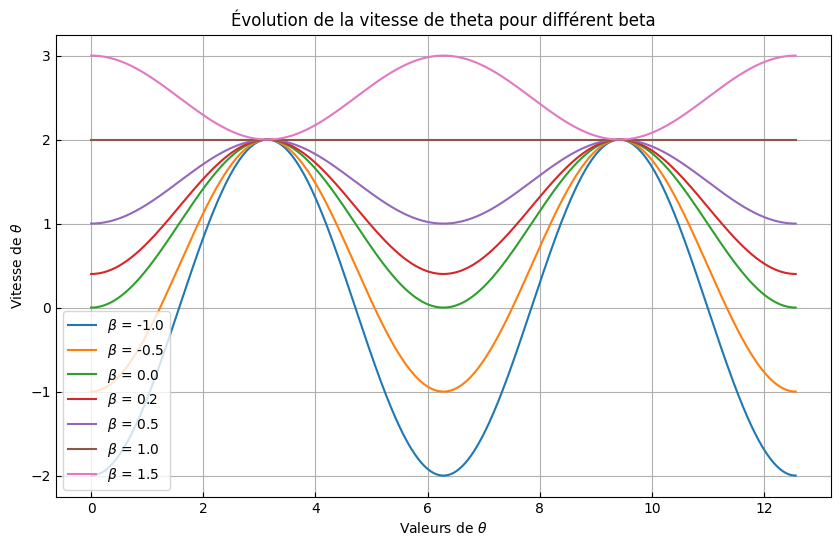

In [119]:
# Variation de la vitesse de theta selon theta pour plusieurs beta.
theta_list = np.linspace(0, 4*np.pi, 1000)
beta_list = np.array([-1, -0.5, 0, 0.2, 0.5, 1, 1.5])

plt.figure(figsize=(10, 6))

for beta in beta_list:
  plt.plot(theta_list, theta_model(theta_list, beta), label=fr'$\beta$ = {beta}')#+f' {beta}'
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"Vitesse de $\theta$")
plt.title("Évolution de la vitesse de theta pour différent beta")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

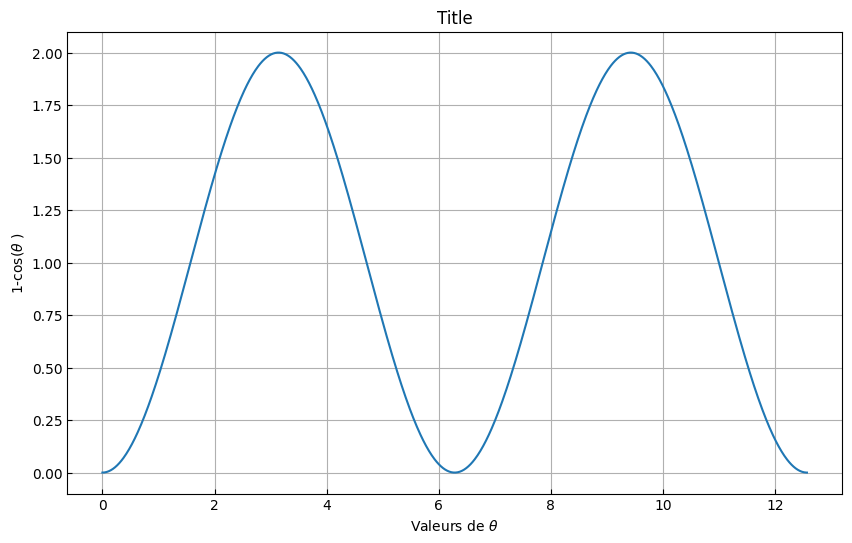

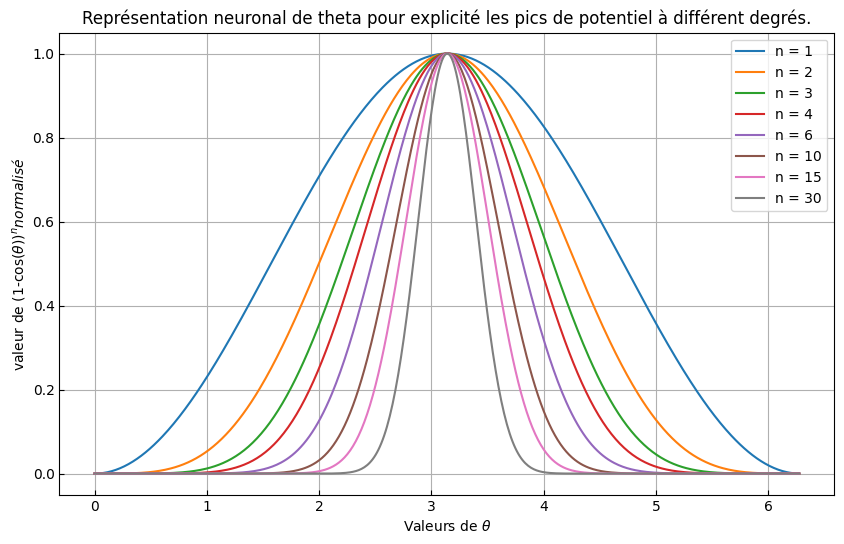

In [107]:
# Dynamique 1-cos(theta) et déffinition du pic
theta_list = np.linspace(0, 4*np.pi, 1000)
beta_list = np.array([-2, -1, -0.5, 0, 0.01, 0.1, 0.5, 1, 2])
spike_list = np.array([1, 2, 3, 4, 6, 10, 15, 30])
plt.figure(figsize=(10, 6))
plt.plot(theta_list, spike_rep(theta_list))
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"1-cos($\theta$ )")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
half_theta = theta_list[:int(len(theta_list)/2)]
for i in spike_list:
  ydata = spike_rep(half_theta, i)
  plt.plot(half_theta, ydata/2**i, label=f'n = {i}')
plt.xlabel(r"Valeurs de $\theta$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n normalisé$")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel à différent degrés.")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

theta = [0.00000000e+00 2.00000000e-03 4.00001800e-03 ... 6.29227294e+00
 6.29427331e+00 6.29627387e+00]
(1-cos($\theta$)$)^10$ = [0.00000000e+00 9.99996667e-61 1.04865639e-54 ... 1.40729927e-47
 7.52357248e-46 2.07574739e-44]


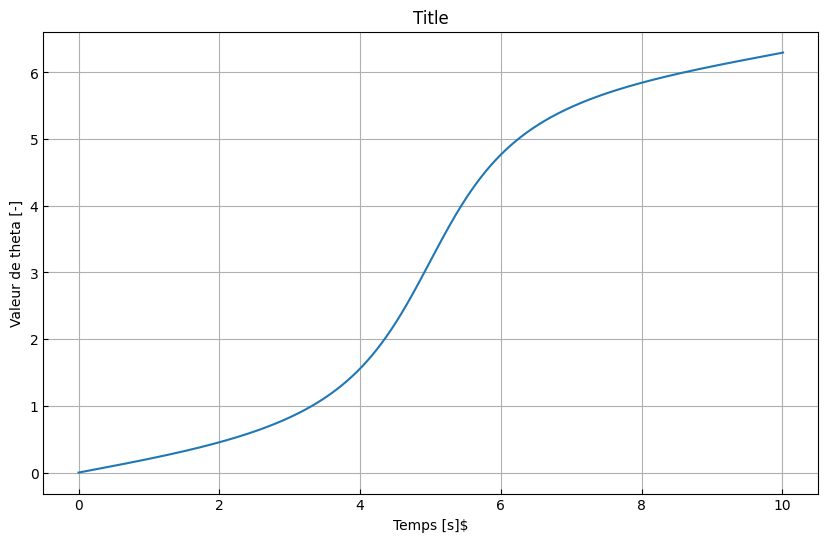

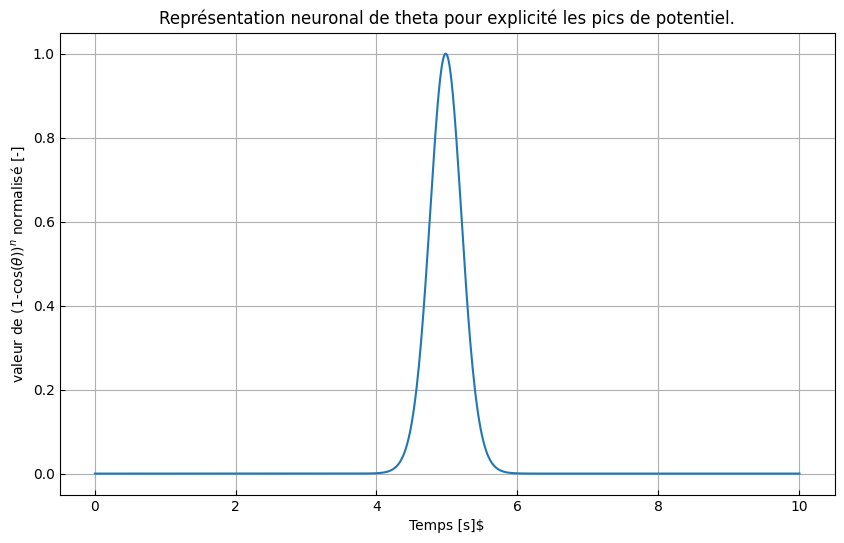

In [ ]:
# Dynamique one spike  ---->  theta0 = 0      beta0 = 0.1    T = 10s
theta_0 = 0
beta_0 = 0.1

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
print(f'theta = {theta}')
print(fr'(1-cos($\theta$)$)^10$ = {(1-np.cos(theta))**10/2**10}')

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title("Title")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, (1-np.cos(theta))**10/2**10)
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^n$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

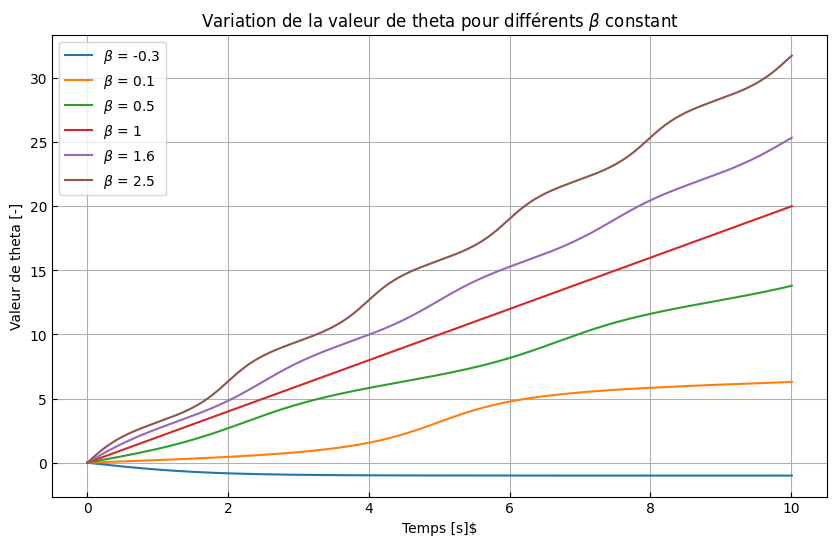

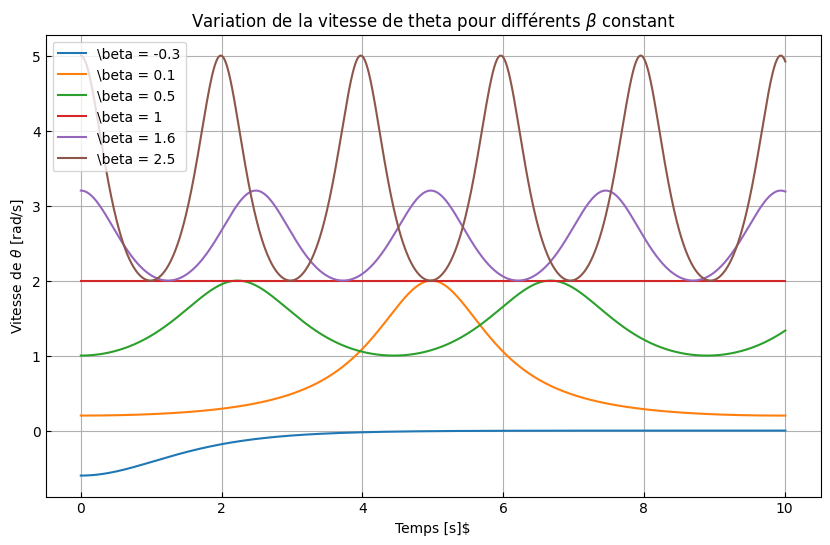

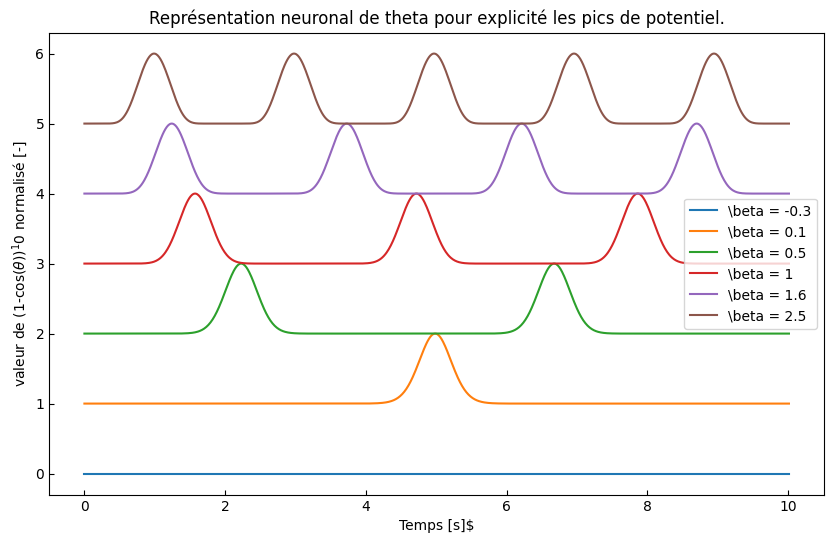

In [432]:
# Dynamique beta0 constant positif -----> effet sur theta  T = 10s
theta_0 = 0
beta_0_list = [-0.3, 0.1, 0.5, 1, 1.6, 2.5]

time_start = 0
time_step = 0.01
time_stop = 10
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta, label = fr'$\beta$ = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Valeur de theta [-]")
plt.title(r"Variation de la valeur de theta pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for beta_0 in beta_0_list:
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, theta_model(theta, beta_0), label = fr'\beta = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de theta pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
for i, beta_0 in enumerate(beta_0_list):
    theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_const)
    plt.plot(time_list, i+(1-np.cos(theta))**10/2**10, label = fr'\beta = {beta_0}')
plt.xlabel(r"Temps [s]$")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.legend()
plt.show()

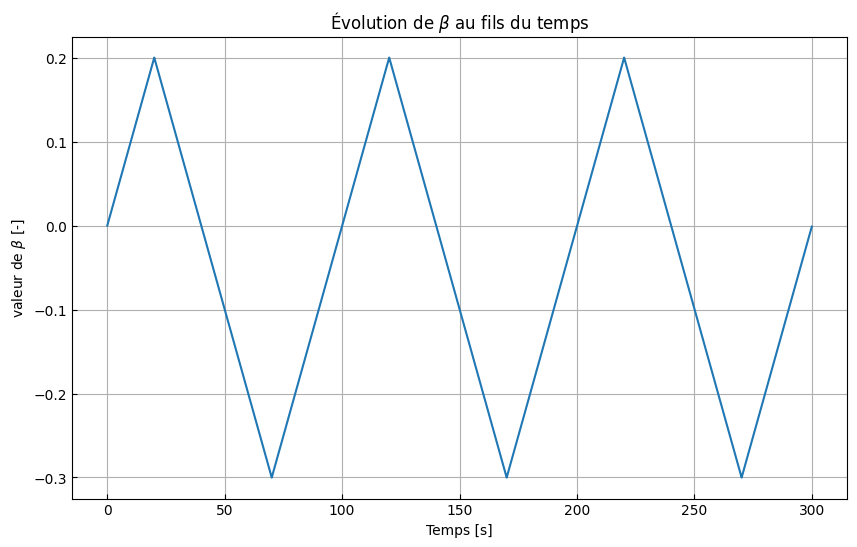

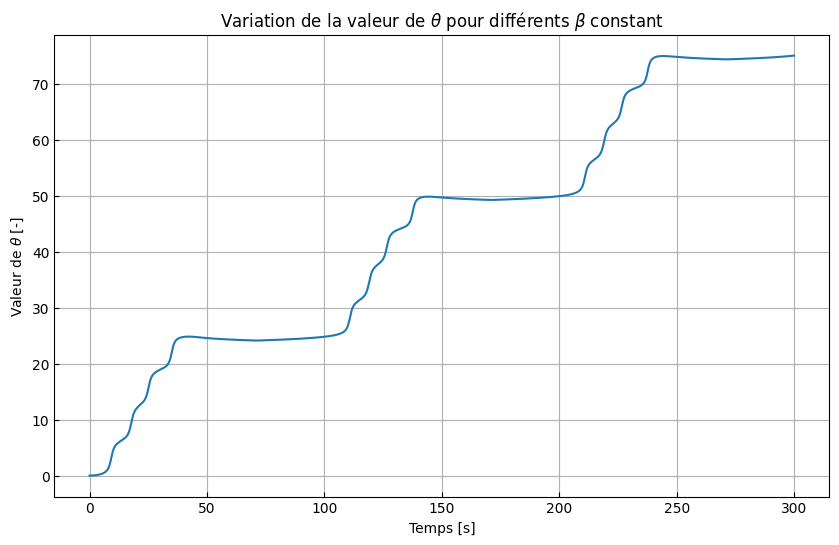

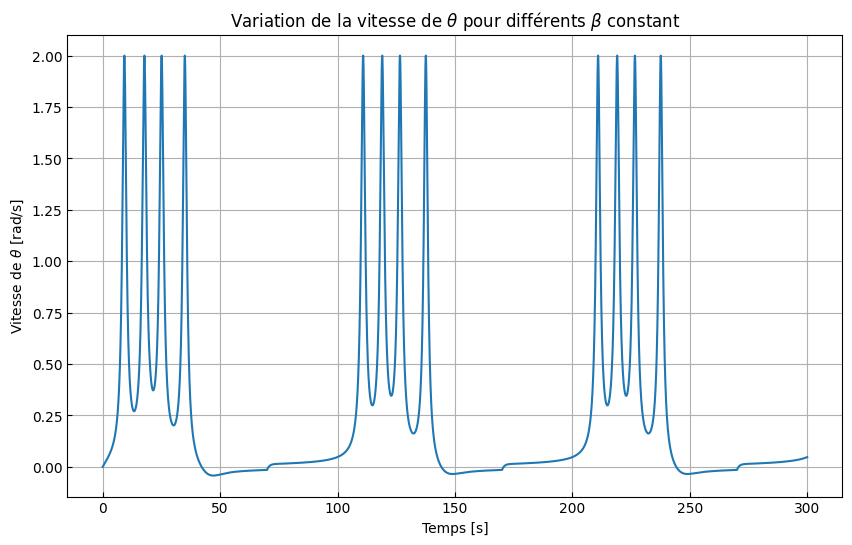

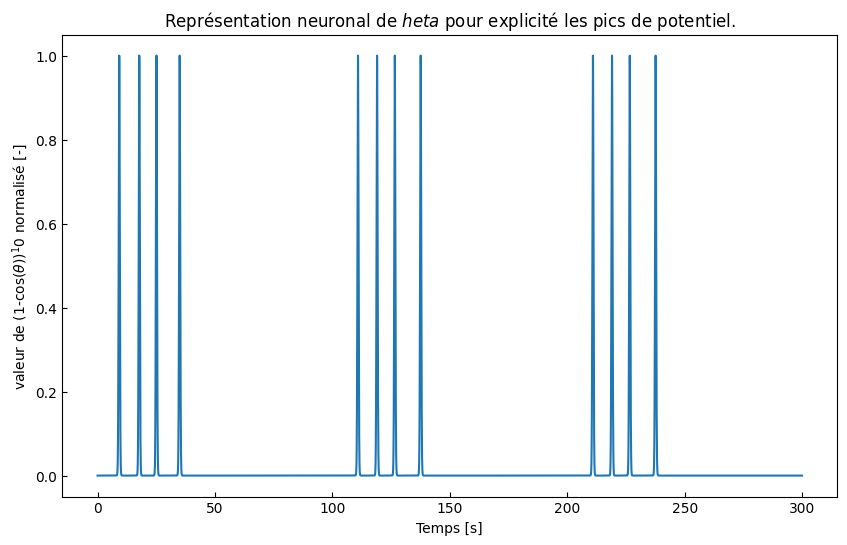

In [433]:
# Dynamique beta oscillant entre 0.2 et -0.3 a vitesse constante.
theta_0 = 0
beta_0  = 0 # Interessant de voir l'effet sur la vitesse de theta quand beta0 = 1.5
time_start = 0
time_step = 0.01
time_stop = 300
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique(time_step, time_stop, theta_0, beta_0, theta_model, beta_Vconst, -0.01,  0.01)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta$ [-]")
plt.title(r"Variation de la valeur de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta, beta))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$ pour différents $\beta$ constant")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta, 10)/2**10)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^10$ normalisé [-]")
plt.title("Représentation neuronal de $\theta$ pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.show()




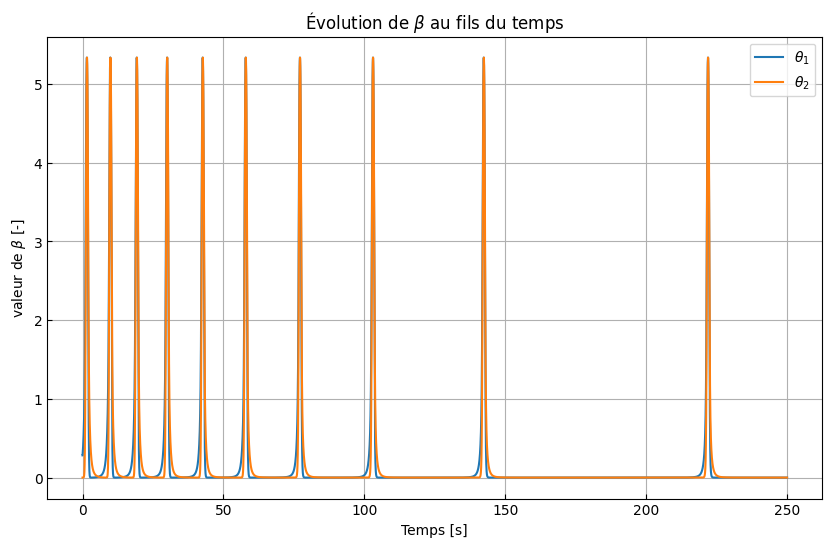

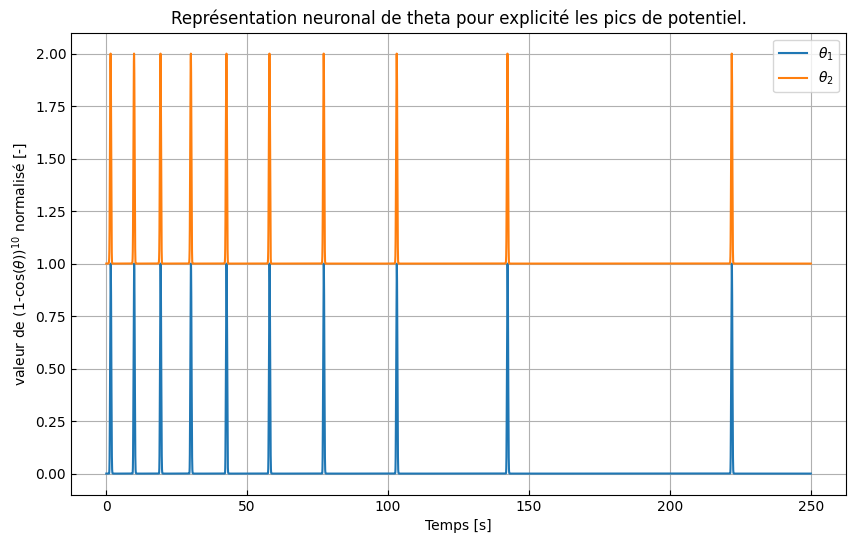

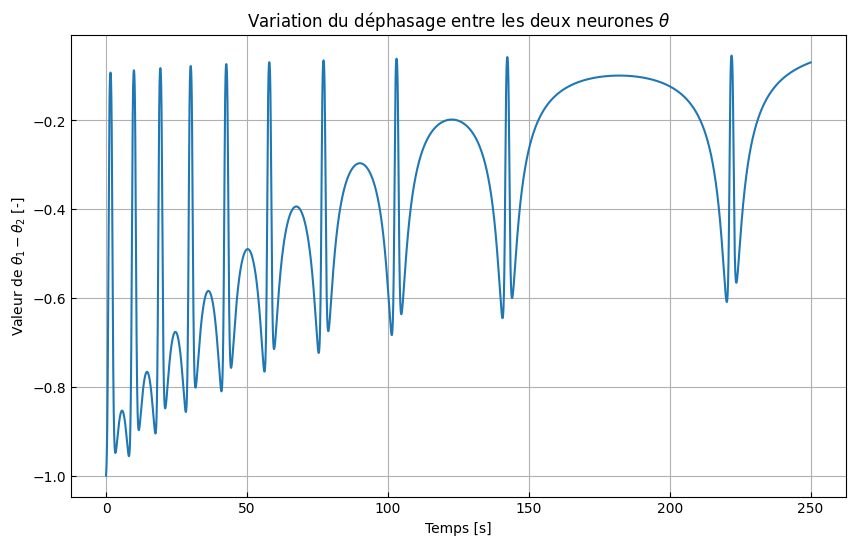

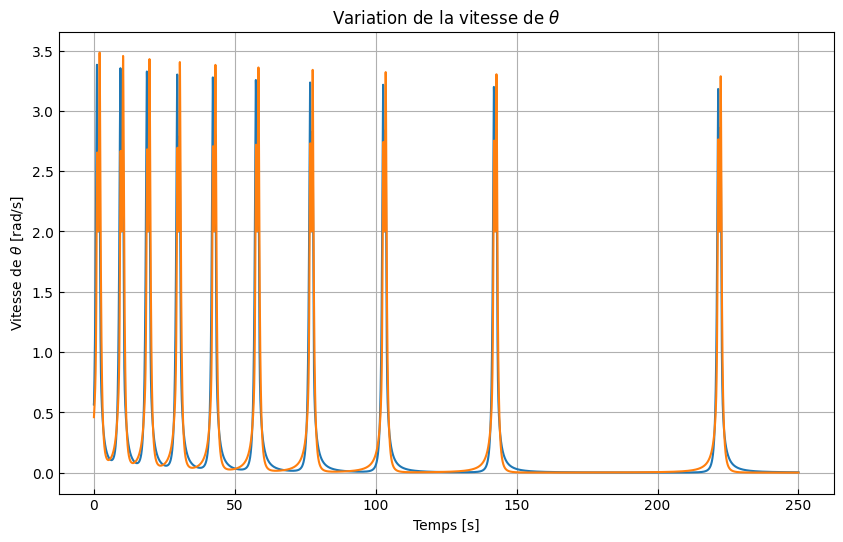

In [485]:
# Dynamique 2 neurone theta.
theta_0 = np.array([[0], [1]])
time_start = 0
time_step = 0.01
time_stop = 250
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique2neurones(time_step, time_stop, theta_0, theta_model, beta2neurones, 2, 0, 2)

plt.figure(figsize=(10, 6))
plt.plot(time_list, beta[0], label = r'$\theta_1$')
plt.plot(time_list, beta[1], label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(time_list, spike_rep(theta[0], 10)/2**10, label = r'$\theta_1$')
plt.plot(time_list, 1+spike_rep(theta[1], 10)/2**10, label = r'$\theta_2$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta[0]-theta[1])
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Valeur de $\theta_1-\theta_2$ [-]")
plt.title(r"Variation du déphasage entre les deux neurones $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(time_list, theta_model(theta[0], beta[0]))
plt.plot(time_list, theta_model(theta[1], beta[1]))
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.show()

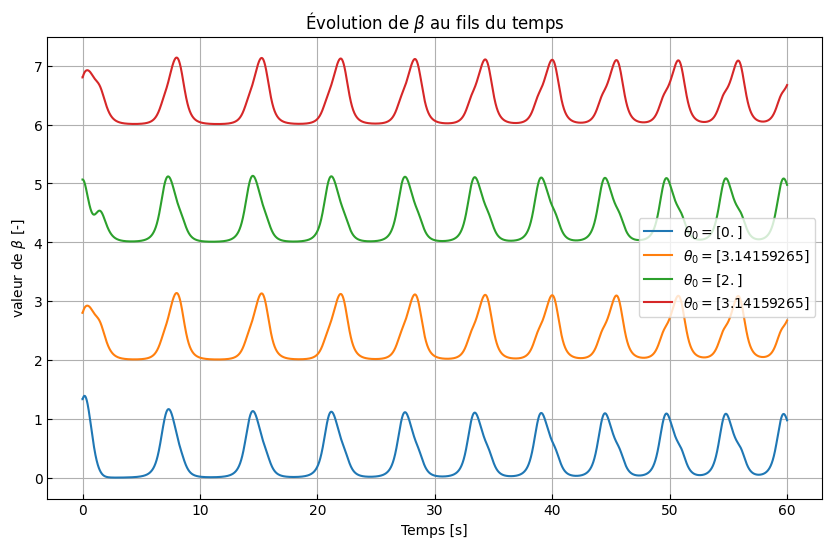

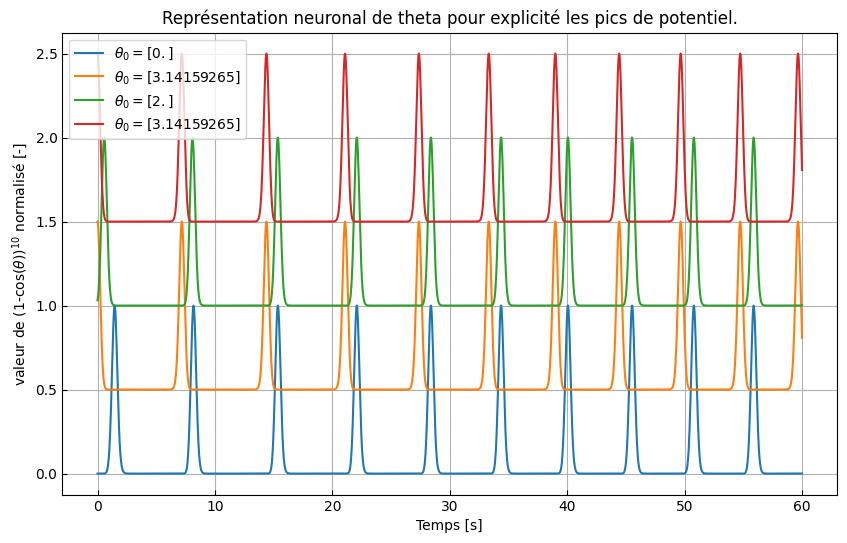

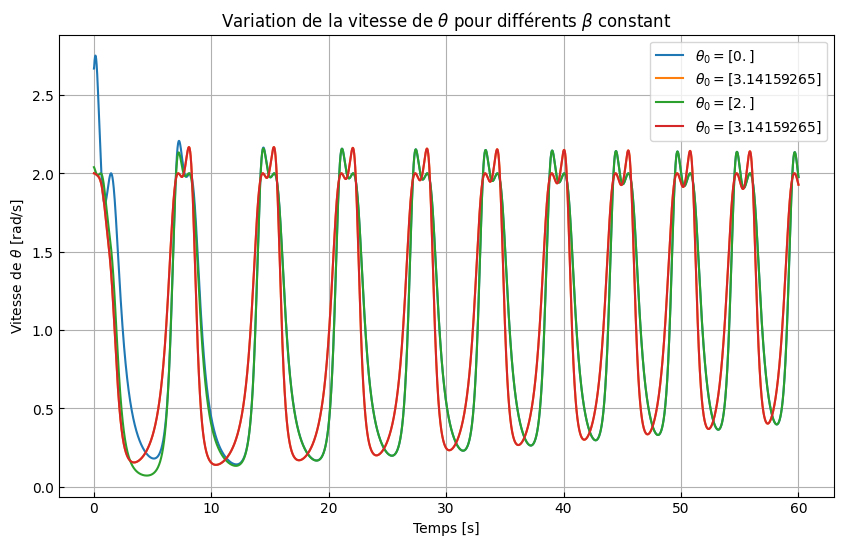

In [ ]:
# Dynamique N neurone theta.
theta_0 = np.array([[0], [np.pi], [2], [np.pi]])
A = np.array([[0, 1, 1, 1], [1, 0, 1, 1], [1, 1, 0, 1], [1, 1, 1, 0]])
time_start = 0
time_step = 0.01
time_stop = 60
time_list = np.linspace(time_start, time_stop+time_step, int(time_stop/time_step)+1)


theta, beta = dynamique2neurones(time_step, time_stop, theta_0, theta_model, betaNneurones, A, 2, 0, 0.8)

plt.figure(figsize=(10, 6))
for i in range(len(theta_0)):
    plt.plot(time_list, 2*i+beta[i], label = fr'$\theta_0={theta_0[i]}$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de $\beta$ [-]")
plt.title(r"Évolution de $\beta$ au fils du temps")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for i in range(len(theta_0)):
    plt.plot(time_list, i*0.5+spike_rep(theta[i], 10)/2**10, label = fr'$\theta_0={theta_0[i]}$')
    # plt.plot(time_list, np.ones(np.shape(time_list)), linewidth = 2)
    # plt.plot(time_list, spike_rep(theta[i], 10)/2**10)
plt.xlabel(r"Temps [s]")
plt.ylabel(r"valeur de (1-cos$(\theta ))^{10}$ normalisé [-]")
plt.title("Représentation neuronal de theta pour explicité les pics de potentiel.")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(theta_0)):
    plt.plot(time_list, theta_model(theta[i], beta[i]), label = fr'$\theta_0={theta_0[i]}$')
plt.xlabel(r"Temps [s]")
plt.ylabel(r"Vitesse de $\theta$ [rad/s]")
plt.title(r"Variation de la vitesse de $\theta$")
plt.tick_params(direction = 'in')
plt.grid(True)
plt.legend()
plt.show()